In [1]:
# load 

import sys
import os 
# path of data 
def set_path():
    if sys.platform == 'darwin':
        print("Current system is macOS")
        main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
    elif sys.platform == 'linux':
        print("Current system is Ubuntu")
        main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
    else:
        print("Current system is neither macOS nor Ubuntu")
    os.chdir(main_fold_path)
set_path()
import glob

import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import cross_val_score,train_test_split
from utils.utils_mine import*
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import collections
from utils.fnirs_utils import read_demographic, read_clinical_history, read_psychiatry_history, read_HAMD_ALL_HISTORY



def read_from_file(example_path): # Open the file and read through the first few lines to find where the data starts
    with open(example_path, 'r') as file:
        lines = file.readlines()
        data_start_line = None
        for i, line in enumerate(lines):
            if 'Data' in line:  # This should match the unique identifier of the data section
                data_start_line = i + 1
                # print(lines[data_start_line])
                break

    if data_start_line is not None:

        # Read the data section, skipping the lines of the metadata
        data = pd.read_csv(example_path, skiprows=data_start_line)

        # Now you have metadata and data as separate DataFrames
        # print(data)
    else:
        print("Data section not found.")
        
    np_data = data.to_numpy()
    ch_data = np_data[:, 1:1+52]

    return ch_data

def get_file_name(path, rest):
    file_pattern = os.path.join(path, rest)
    file_list = glob.glob(file_pattern)
    return file_list

def check_replicate_subject(all_subject):
    all_subject_index = [i[3:] for i in all_subject]
    all_subject_index = np.array(all_subject_index).astype(int)
    print(f'all_subject_index -> {all_subject_index}')
    print('all_subject_index.shape -> ', all_subject_index.shape)
    print('len(np.unique(all_subject_index)) -> ', len(np.unique(all_subject_index)))
    is_replicated = len(np.unique(all_subject_index)) != len(all_subject_index)
    print(f"Is there any replicated number in all_subject_index? {is_replicated}")
    if is_replicated:
        replicated_elements = [item for item, count in collections.Counter(all_subject_index).items() if count > 1]
        replicated_indices = np.where(np.isin(all_subject_index, replicated_elements))[0]
        print(f" Element {replicated_elements} shows up in the following indices: {replicated_indices}")
    print(f' now will return replicated_indices[0::2]')
    return replicated_indices[0::2]


follow_up_fold = 'allData/RawData'
T8_path = follow_up_fold + '/T8_fnirs/Session 2_VFT'
base_patient_path = follow_up_fold + '/Baseline_fnirs/Patients'
cli_path = 'allData/fNIRS x MDD Data_Demographics_Clinical.xlsx'

cgi_sgs_data = pd.read_excel(cli_path, sheet_name='SDS_CGI_All Timepoints')


excel_data = pd.read_excel(cli_path, sheet_name='Summary T0T8_fNIRS Analysis')

all_involve_subject = ['PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009',
       'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016',
       'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023',
       'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030',
       'PT031', 'PT032', 'PT033', 'PT034', 'PT036', 'PT037', 'PT038',
       'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045',
       'PT046', 'PT047', 'PT048', 'PT049', 'PT050', 'PT051', 'PT054',
       'PT057', 'PT058', 'PT059', 'PT060', 'PT061', 'PT062', 'PT063',
       'PT064', 'PT065', 'PT066', 'PT067', 'PT068', 'PT069', 'PT070',
       'PT071']

def impute_nan_data(data):
    input = data.copy()
    from sklearn.experimental import enable_iterative_imputer
    # Now you can import IterativeImputer
    from sklearn.impute import IterativeImputer


    # Create an instance of IterativeImputer
    imputer = IterativeImputer()

    # Fit the imputer on the clinical_data ndarray
    imputer.fit(input)

    # Transform the clinical_data ndarray by imputing the NaN values
    imputed_data = imputer.transform(input)
    return imputed_data

hamd_timeline = pd.read_excel(cli_path, sheet_name='TimelineHAMD')
data = {}
for i in range(9):
    name = hamd_timeline.values[0, i]
    value = hamd_timeline.values[1:, i]
    data[name] = value
data = pd.DataFrame(data)
filter_values = data[data['Subject ID'].isin(all_involve_subject)]
filter_values = filter_values.values 
filter_values = filter_values[:, 1:]
hamd_timeline_values = impute_nan_data(filter_values).astype(int)

avg_hamd_timeline = np.mean(hamd_timeline_values, axis=0)
nine_region_name = ['L-pSFC', 'R-pSFC', 'L-dlPFC', 'R-dlPFC', 'L-STG', 'R-STG', 'L-vlPFC', 'R-vlPFC', 'mPFC']



Current system is Ubuntu


2024-06-26 13:34:51.523782: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 13:34:51.541329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 13:34:51.541346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 13:34:51.541351: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 13:34:51.545161: I tensorflow/core/platform/cpu_feature_g

region_i*9 + i 0
region_i*9 + i 1
region_i*9 + i 2
region_i*9 + i 3
region_i*9 + i 4
region_i*9 + i 5
region_i*9 + i 6
region_i*9 + i 7
region_i*9 + i 8
region_i*9 + i 9
region_i*9 + i 10
region_i*9 + i 11
region_i*9 + i 12
region_i*9 + i 13
region_i*9 + i 14
region_i*9 + i 15
region_i*9 + i 16
region_i*9 + i 17
region_i*9 + i 18
region_i*9 + i 19
region_i*9 + i 20
region_i*9 + i 21
region_i*9 + i 22
region_i*9 + i 23
region_i*9 + i 24
region_i*9 + i 25
region_i*9 + i 26
region_i*9 + i 27
region_i*9 + i 28
region_i*9 + i 29
region_i*9 + i 30
region_i*9 + i 31
region_i*9 + i 32
region_i*9 + i 33
region_i*9 + i 34
region_i*9 + i 35
region_i*9 + i 36
region_i*9 + i 37
region_i*9 + i 38
region_i*9 + i 39
region_i*9 + i 40
region_i*9 + i 41
region_i*9 + i 42
region_i*9 + i 43
region_i*9 + i 44
region_i*9 + i 45
region_i*9 + i 46
region_i*9 + i 47
region_i*9 + i 48
region_i*9 + i 49
region_i*9 + i 50
region_i*9 + i 51
region_i*9 + i 52
region_i*9 + i 53
region_i*9 + i 54
region_i*9 + i 55
re

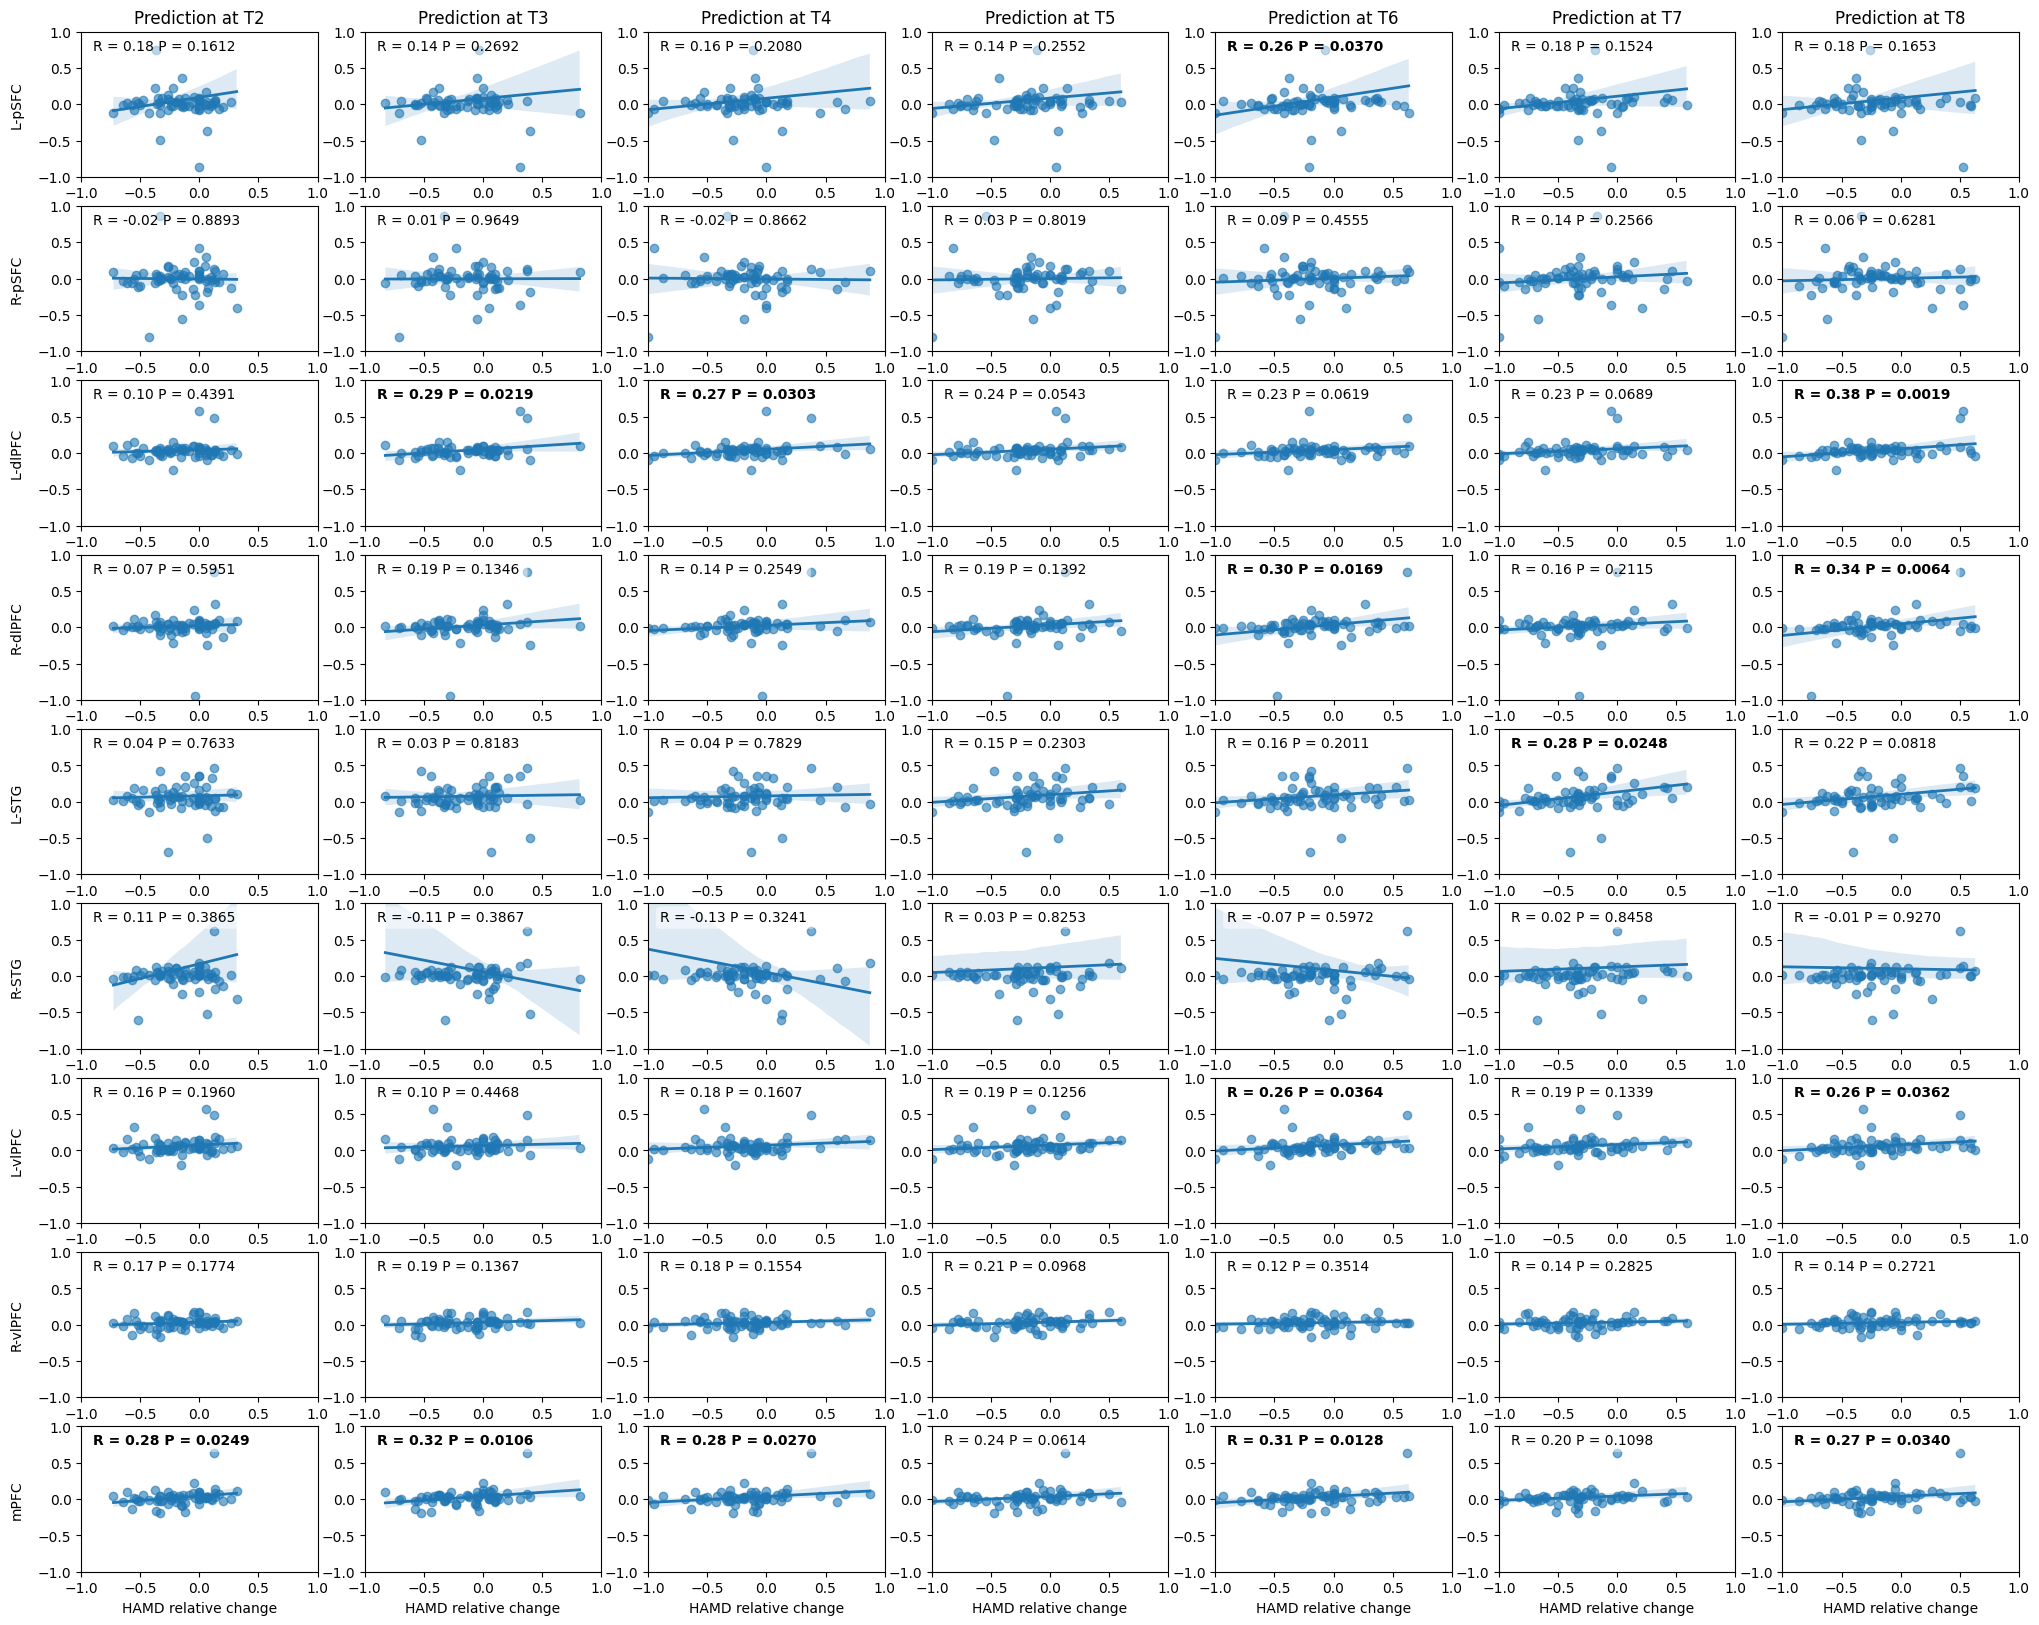

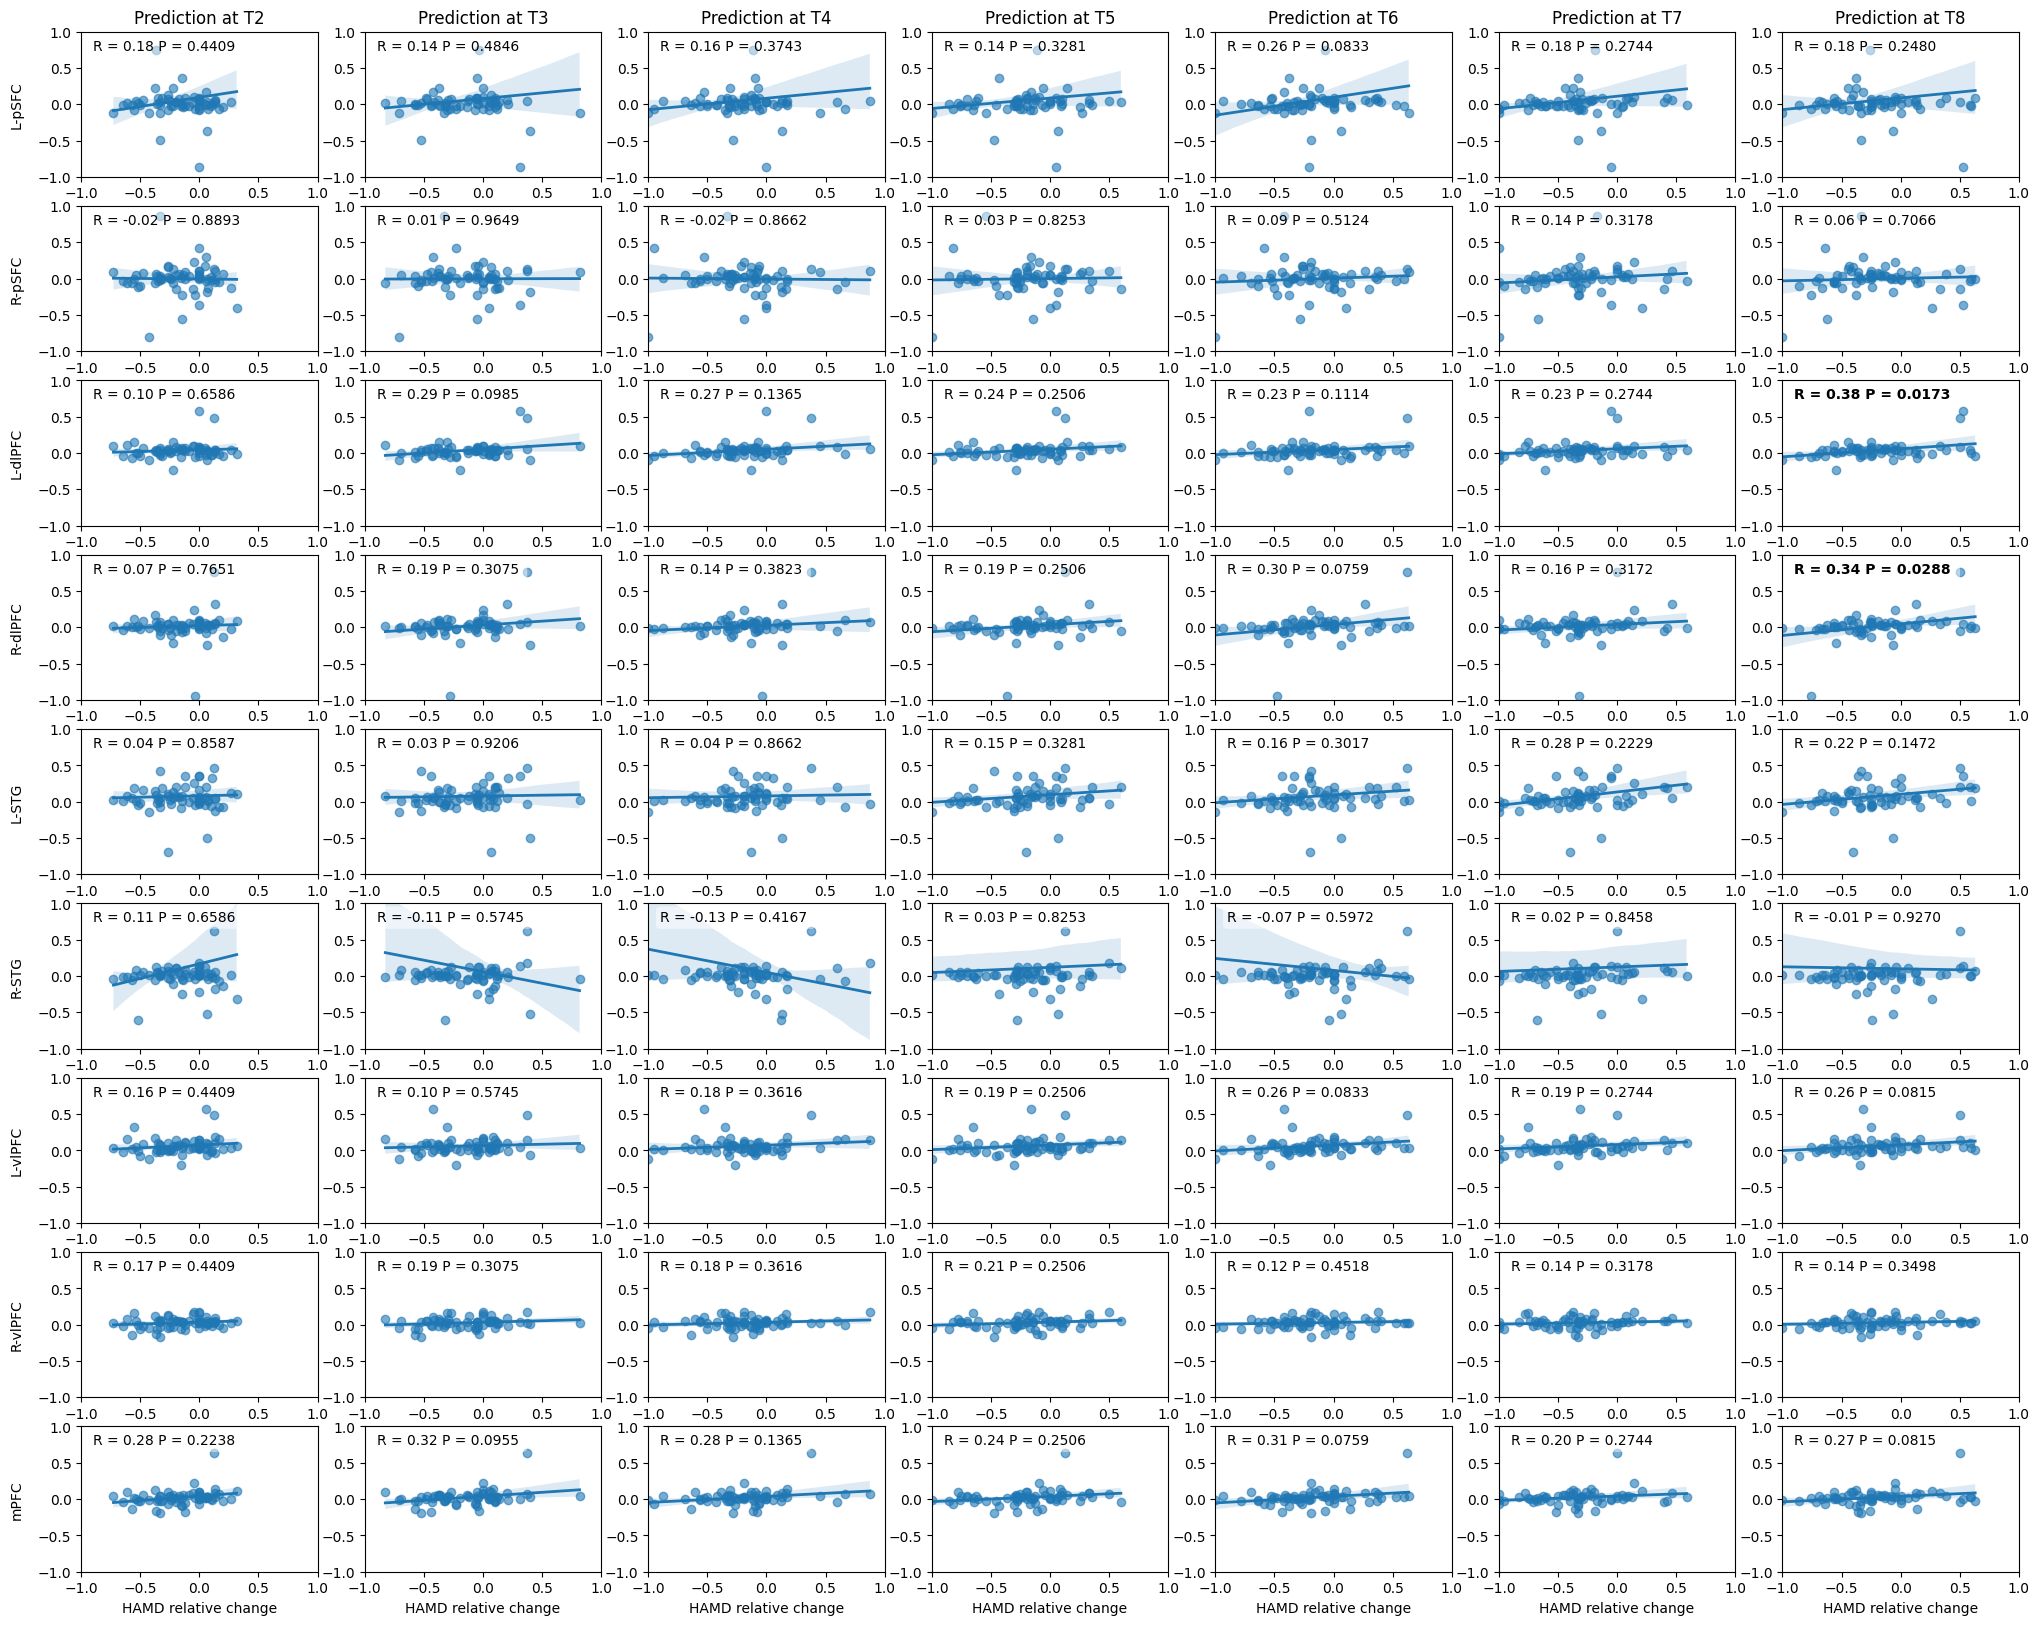

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# read task change hbt especailly dpc 

def plot_reg(labels, preds, ax, correct_p_value):
    
    r, p_value = pearsonr(labels, preds)
    if correct_p_value is not None:
        p_value = correct_p_value
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={'alpha':0.6}, line_kws={"linewidth":2})
    bold = True if p_value < 0.05 else False
    ax.text(0.05, 0.95, f'R = {r:.2f} P = {p_value:.4f} ',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.5), fontsize=10, fontweight='bold' if bold else 'normal')
    ax.set_ylim([-1, 1])  # Set y-axis limits
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])  # Set y-axis ticks
    ax.set_xlim([-1, 1])  # Set y-axis limits
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])  # Set y-axis ticks    
    # Calculate Pearson correlation
    return p_value


task_change_hbt = np.load('allData/prognosis_mix_hb/pretreatment_response/task_change_hb.npy')[:, :, -1]

new_avg_hame_timeline = hamd_timeline_values.copy()
# print('hamd_timeline_values', hamd_timeline_values)
# print('new_avg_hame_timeline shape', new_avg_hame_timeline.shape)
# for i in range(1, hamd_timeline_values.shape[1]):
#     if i != hamd_timeline_values.shape[1]-1:
#         new_avg_hame_timeline[:, i] = (hamd_timeline_values[:, i] + hamd_timeline_values[:, i+1] + hamd_timeline_values[:, i-1]) / 3
#     else:
#         new_avg_hame_timeline[:, i] = (hamd_timeline_values[:, i] + hamd_timeline_values[:, i-1]) / 2

all_p_values = []

number_of_region = 9
num_of_timeline = avg_hamd_timeline.shape[0]-1

# two times is to calcualte the FDR correct p_values 
for p_correct_index in range(2):       
    
    fig, axs = plt.subplots(number_of_region, 7, figsize=(25, 20))
    new_avg_hame_timeline = hamd_timeline_values.copy()       
                  
    for region_i in range(number_of_region):              
        for i in range(num_of_timeline):
            label = (new_avg_hame_timeline[:, i+1] - new_avg_hame_timeline[:, 0]) / new_avg_hame_timeline[:, 0]
            # sns.regplot(label, task_change_hbt[:, 0])
            # sns.regplot(x=label, y=task_change_hbt[:, 0], scatter_kws={'alpha':0.6}, line_kws={"linewidth":2})
            print('region_i*9 + i', region_i*num_of_timeline + i)
            correct_p_value = all_p_values[region_i*num_of_timeline + i] if p_correct_index == 1 else None
            p_value = plot_reg(label, task_change_hbt[:, region_i], axs[region_i, i], correct_p_value=correct_p_value)
            
            if i == 0:
                axs[region_i, i].set_ylabel(f'{nine_region_name[region_i]}', labelpad=10)
            if region_i == 0:
                axs[region_i, i].set_title(f"Prediction at T{i+2}")
            if region_i == number_of_region-1:
                axs[region_i, i].set_xlabel(f'HAMD relative change')
            
            if p_correct_index == 0: all_p_values.append(p_value)
    
    all_p_values = np.array(all_p_values).reshape(number_of_region, num_of_timeline)
    for i in range(num_of_timeline):
        all_p_values[:, i] = multipletests(all_p_values[:, i], alpha=0.05, method='fdr_bh')[1]
    all_p_values = all_p_values.flatten().tolist()


        
# plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

In [11]:
7*9

63